[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/babbu3682/Med_ChatGPT_tutorial/blob/main/Notebook/colab/Hands_On_Train_Base.ipynb)

- ##### '파일' -> '드라이브에 사본 저장' 클릭

In [ ]:
# 필요한 라이브러리 설치
!pip install pydicom
!pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg # GDCM 에러 해결

In [ ]:
# 코랩에서 한글깨짐 현상 해결 코드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt # matplotlob import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

In [ ]:
# google colab과 google drive 연동 (마운트)
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# # /content에 Med_ChatGPT_tutorial 폴더가 생성됨.
# !git clone https://github.com/babbu3682/Med_ChatGPT_tutorial.git

In [ ]:
# 정리:
# 위의 두 코드를 실행했다면,
# 데이터 경로는 /content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset
# 코드 경로는 /content/Med_ChatGPT_tutorial

In [ ]:
# 런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU 클릭 -> 저장

In [ ]:
!nvidia-smi # GPU 정보 확인하기
import os
print("CPU 갯수 = ", os.cpu_count()) # CPU 갯수 확인하기

# Training process

## 0. Fix Seed

In [ ]:
'''
[Seed Fixed]
===INSTRUCT===
파이토치 및 파이썬에서 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요. 

===TASK===
재현성을 위해 numpy, pytorch, cuda, and random 라이브러리의 무작위성을 고정하는 코드를 작성해주세요.
'''

In [ ]:
import numpy as np
import torch
import random

# Numpy
seed = 42
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Random
random.seed(seed)


## 1. Dataset

In [ ]:
'''
[Create Dataset]
===INSTRUCT===
파이토치 및 파이썬에서 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요. 
dicom image 처리 및 증강을 포함하는 binary classification 작업용 딥러닝 프레임워크를 기반으로 데이터셋 클래스를 생성해 주세요.
PyTorch의 "Dataset"을 상속받는 맞춤형 데이터셋 클래스 "RSNA_Dataset"을 생성하는 코드입니다.
이미지의 경로가 포함된 csv 파일('rsna_data.csv')을 읽어들여서 데이터셋을 생성해 주세요.
이미 'rsna_data.csv'의 'mode'열로 'train', 'valid'로 데이터를 구분해 두었습니다.
'albumentations' 라이브러리를 사용하여 데이터 전처리 및 증강을 수행하는 compose transform 함수를 정의합니다. 
'mode'에 따라 증강을 다르게 적용합니다.
'train' 모드 증강으로는, Resize(224x224), min_max_normalization, 텐서 변환을 수행합니다. 
'valid' 모드 증강으로는, Resize(224x224), min_max_normalization, 텐서 변환을 수행합니다. 

===INFO===
csv_file = '/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/rsna_data.csv'
target_class = 'cancer'

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. csv 파일을 읽습니다.
    2. 초기단계에서 해당 'mode'에 따라 데이터 프레임을 필터링 합니다.
    3. 데이터 프레임의 'path'열을 사용하여 파일 경로, 'cancer'열을 사용하여 라벨 정보를 읽습니다.
    4. DICOM 파일의 픽셀 배열에 Modality Lookup Table (LUT)를 적용합니다.
    5. 해당 'mode'에 따른 augmentation을 적용합니다.
    6. 읽은 이미지와 해당 라벨을 반환합니다.
'''

In [ ]:
import pandas as pd
import pydicom
import numpy as np
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize, Normalize
import albumentations as A
import torch

class RSNA_Dataset(Dataset):
    def __init__(self, csv_file, mode, target_class):
        # csv 파일 읽기
        self.dataframe = pd.read_csv(csv_file)
        # 초기 단계에서 'mode'에 따라 데이터 프레임 필터링
        self.dataframe = self.dataframe[self.dataframe['mode'] == mode]
        # 라벨 컬럼명
        self.target_class = target_class
        # 'mode'에 따른 Augmentation 설정
        if mode == 'train':
            self.transform = Compose([
                Resize(224, 224),
                Normalize(),
                ToTensorV2()
            ])
        elif mode == 'valid':
            self.transform = Compose([
                Resize(224, 224),
                Normalize(),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # 이미지 파일 경로 읽기
        img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('path')]
        # DICOM 파일 읽기
        dicom = pydicom.dcmread(img_path)
        # LUT 적용
        img = dicom.pixel_array
        img = img * dicom.RescaleSlope + dicom.RescaleIntercept
        # 이미지 Augmentation
        img = self.transform(image=img)['image']

        # 라벨 정보 읽기
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc(self.target_class)]

        return img, label


In [ ]:
'''
[Code Completion]
===INSTRUCT===
파이토치 및 파이썬에서 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요. 
위 코드에 불완전한 부분이 있습니다. 코드를 다시 작성하여 완성도를 높여주세요. 

===TASK===
다음은 몇 가지 필수 사항입니다:
    1. 굳이 target_class에 변수를 부여하지 않아도 됩니다. target_class는 항상 'cancer' 입니다.
    2. A.Normalize() 대신 min_max_normalization 함수를 생성하고, 이를 이용하여 normalize 하세요.
'''

In [ ]:
import pandas as pd
import pydicom
import numpy as np
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize
import albumentations as A
import torch

class RSNA_Dataset(Dataset):
    def __init__(self, csv_file, mode):
        # csv 파일 읽기
        self.dataframe = pd.read_csv(csv_file)
        # 초기 단계에서 'mode'에 따라 데이터 프레임 필터링
        self.dataframe = self.dataframe[self.dataframe['mode'] == mode]
        # 'mode'에 따른 Augmentation 설정
        if mode == 'train':
            self.transform = Compose([
                Resize(224, 224),
                ToTensorV2()
            ])
        elif mode == 'valid':
            self.transform = Compose([
                Resize(224, 224),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # 이미지 파일 경로 읽기
        img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('path')]
        # DICOM 파일 읽기
        dicom = pydicom.dcmread(img_path)
        # LUT 적용
        img = dicom.pixel_array
        img = img * dicom.RescaleSlope + dicom.RescaleIntercept
        # Min-Max 정규화
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        # 이미지 Augmentation
        img = self.transform(image=img)['image']

        # 라벨 정보 읽기
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('cancer')]

        return img, label


In [ ]:
'''
[Code Completion]
===INSTRUCT===
파이토치 및 파이썬에서 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요. 
위 코드에 불완전한 부분이 있습니다. 코드를 다시 작성하여 완성도를 높여주세요. 

===TASK===
다음은 몇 가지 수정사항입니다:
  1. 정규화는 augmentation 다음에 위치하도록 수정해주세요.
  2. label도 텐서로 변형해야 합니다.
'''

In [ ]:
import pandas as pd
import pydicom
import numpy as np
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize
import albumentations as A
import torch

class RSNA_Dataset(Dataset):
    def __init__(self, csv_file, mode):
        # csv 파일 읽기
        self.dataframe = pd.read_csv(csv_file)
        # 초기 단계에서 'mode'에 따라 데이터 프레임 필터링
        self.dataframe = self.dataframe[self.dataframe['mode'] == mode]
        # 'mode'에 따른 Augmentation 설정
        if mode == 'train':
            self.transform = Compose([
                Resize(224, 224),
                ToTensorV2()
            ])
        elif mode == 'valid':
            self.transform = Compose([
                Resize(224, 224),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # 이미지 파일 경로 읽기
        img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('path')]
        # DICOM 파일 읽기
        dicom = pydicom.dcmread(img_path)
        # LUT 적용
        img = dicom.pixel_array
        img = img * dicom.RescaleSlope + dicom.RescaleIntercept
        # 이미지 Augmentation
        img = self.transform(image=img)['image']
        # Min-Max 정규화 (Augmentation 이후에 적용)
        img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))

        # 라벨 정보 읽기
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('cancer')]
        # 라벨을 텐서로 변환
        label = torch.tensor(label, dtype=torch.float32)

        return img, label


In [ ]:
# Continue writing please

# "train_dataset" 및 "valid_dataset"을 생성하고 이를 "train_loader" 및 "valid_loader"에 로드하는 DataLoader를 생성합니다. 

In [ ]:
from torch.utils.data import DataLoader

# 훈련 및 검증 데이터셋 로드
train_dataset = RSNA_Dataset(csv_file="/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/rsna_data.csv", mode="train")
valid_dataset = RSNA_Dataset(csv_file="/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/rsna_data.csv", mode="valid")

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

In [ ]:
a = next(iter(train_loader))
b = next(iter(valid_loader))

In [ ]:
a[1]

In [ ]:
a[0].shape

## 2. Network

In [ ]:
'''
[Build a Neural Network]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
'Pytorch'를 사용하여 인기있는 비전 신경망 'ResNet50'을 구축해 주세요.
입력 채널과 출력 채널은 '1'입니다.

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. 비전 신경망 라이브러리를 임포트합니다.
    2. 모델 'ResNet50' class를 선언합니다.
    3. 학습 가능한 파라미터 수를 계산합니다.
'''

In [ ]:
import torch
from torch import nn
from torchvision.models import resnet50

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        # torchvision에서 제공하는 ResNet50 모델 로드
        self.model = resnet50(pretrained=False)
        # 입력 채널을 1로 변경
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # 출력 채널을 1로 변경
        self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        x = self.model(x)
        return x

# 모델 선언
model = ResNet50()

# 훈련 가능한 매개변수의 수 계산
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"훈련 가능한 매개변수의 수: {trainable_params}")

## 3. Multi-GPU

In [ ]:
'''
[Multi-GPU Training]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
멀티 GPU를 사용하여 모델을 학습하고자 합니다.

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. 먼저 GPU를 사용할 수 있는지 확인합니다.
    2. multi-gpu를 사용할 수 있는지 확인합니다.
    3. multi-gpu를 사용할 수 있다면, multi-gpu를 사용하여 모델을 래핑합니다.
    4. multi-gpu를 사용할 수 없다면, 단일 GPU를 사용합니다.
'''

In [ ]:
# 필요한 라이브러리 import
import torch
import torch.nn as nn

# GPU가 사용 가능한지 확인
if torch.cuda.is_available():
    device = torch.device("cuda") 
    print("GPU를 사용할 수 있습니다.")
else:
    device = torch.device("cpu")
    print("GPU를 사용할 수 없습니다. CPU를 사용합니다.")

# 멀티-GPU 사용 가능한지 확인
if torch.cuda.device_count() > 1:
    print(f"멀티-GPU를 사용할 수 있습니다. GPU 개수: {torch.cuda.device_count()}")
    model = nn.DataParallel(model)

# 모델을 GPU로 이동
model = model.to(device)


## 4. Loss

In [ ]:
'''
[Define Loss function]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
이진 분류 작업에서 많이 사용되는 손실 함수를 정의하고 손실을 "loss"으로 정의해 주세요.
이 함수에는 'target'와 'logit'이 주어지며, 같은 shape이어야 합니다.
사용 방법에 대한 간단한 예를 제공해주세요.

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. 손실 함수를 정의합니다.
    2. 손실 함수를 사용하는 간단한 예를 제공합니다.
'''

In [ ]:
import torch
import torch.nn.functional as F

# 손실 함수 정의
def loss_fn(logit, target):
    loss = F.binary_cross_entropy_with_logits(logit, target)
    return loss

# 간단한 예시
logit = torch.randn(10, requires_grad=True)  # 모델의 출력을 가정합니다.
target = torch.empty(10).random_(2)  # 이진 타겟 레이블을 가정합니다.
loss = loss_fn(logit, target)

print(f"Loss: {loss.item()}")

## 5. Optimizer

In [ ]:
'''
[Define Optimizer]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
인기 있는 'optimizer' 여러 개를 소개하고, 설계하세요.
학습률은 '1e-4'이고 'weight_dacay'는 '0'입니다.
'optimizer' 하이퍼파라미터의 주요 기능 및 사용 사례에 대해 설명해 주세요.

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. 여러 'optimizer'를 정의합니다.
    2. 각 'optimizer' 하이퍼파라미터의 주요 기능 및 사용 사례에 대해 설명합니다.
'''

In [ ]:
import torch.optim as optim

# # SGD 최적화기
# optimizer_SGD = optim.SGD(model.parameters(), lr=1e-4, weight_decay=0)

# # Momentum 최적화기
# optimizer_Momentum = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0)

# # RMSprop 최적화기
# optimizer_RMSprop = optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=0)

# Adam 최적화기
# optimizer_Adam = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)


## 6. LR scheduler

In [ ]:
'''
[Define learning rate(LR) scheduler]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
인기 있는 'scheduler' 여러 개를 소개하고, 설계하세요.
'scheduler'의 하이퍼파라미터는 default로 설정하고 하이퍼파라미터의 주요 기능 및 사용 사례에 대해 설명해 주세요.

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. 여러 'scheduler'를 정의합니다.
    2. 각 'scheduler' 하이퍼파라미터의 주요 기능 및 사용 사례에 대해 설명합니다.
'''

In [ ]:
from torch.optim import lr_scheduler

# # StepLR 스케줄러
# scheduler_stepLR = lr_scheduler.StepLR(optimizer_Adam, step_size=30, gamma=0.1)

# # MultiStepLR 스케줄러
# scheduler_multiStepLR = lr_scheduler.MultiStepLR(optimizer_Adam, milestones=[30, 80], gamma=0.1)

# # ExponentialLR 스케줄러
# scheduler_expLR = lr_scheduler.ExponentialLR(optimizer_Adam, gamma=0.1)

# ReduceLROnPlateau 스케줄러
# scheduler_ReduceLROnPlateau = lr_scheduler.ReduceLROnPlateau(optimizer_Adam, 'min')

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


## 7. Check the resume point

In [ ]:
'''
[Resume training]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
체크포인트가 있는 경우 체크포인트에서 모델 웨이트를 로드하도록 코딩하세요.

==INFO===
start_epoch     = 0
total_epoch     = 200
checkpoint_dir  = '/content/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Base'
save_dir        = '/content/Med_ChatGPT_tutorial/predictions/230701_ResNet50_Base'

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. 'checkpoint_dir' 및 'save_dir'에 폴더가 존재하지 않는 경우 폴더를 만듭니다.
    2. 'checkpoint_dir'에 체크포인트가 있는지 확인합니다.
    3. 체크포인트가 있는 경우, model weight, optimizer, scheduler, start_epoch를 로드합니다.
'''

In [ ]:
start_epoch     = 0
total_epoch     = 200
checkpoint_dir  = '/content/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Base'
save_dir        = '/content/Med_ChatGPT_tutorial/predictions/230701_ResNet50_Base'

import os
import torch

# 체크포인트 및 저장 디렉토리 생성
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 체크포인트 존재 여부 확인
ckpt_path = os.path.join(checkpoint_dir, 'last_checkpoint.pth')
if os.path.exists(ckpt_path):
    # 체크포인트가 존재하는 경우, 가중치, 옵티마이저, 스케줄러, 시작 에포크 로드
    print("체크포인트 로드 중...")
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    print("체크포인트 로드 완료. 훈련을 {} 에포크부터 재개합니다.".format(start_epoch))
else:
    # 체크포인트가 없는 경우, 초기 에포크로 설정
    print("체크포인트를 찾을 수 없습니다. 훈련을 처음부터 시작합니다.")
    start_epoch = 0



## 8. Metric

In [ ]:
'''
[Define Metrics]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
암 검출을 위한 binary classification task 평가 메트릭에 대한 함수 코드를 정의해 주세요.
사용 방법에 대한 간단한 예제를 알려주세요.

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. 평가 메트릭에 대한 함수 코드를 정의합니다.
    2. 평가 메트릭에 대한 간단한 예제를 제공합니다.
'''

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(target, prediction):
    # 정밀도, 재현율, F1 점수를 계산합니다.
    precision = precision_score(target, prediction)
    recall = recall_score(target, prediction)
    f1 = f1_score(target, prediction)
    
    return precision, recall, f1

In [ ]:
# 이진 분류 평가 지표를 더 추가해 주세요.

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

def calculate_metrics(target, prediction, prob):
    # 정확도, 정밀도, 재현율, F1 점수, AUC-ROC를 계산합니다.
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction)
    recall = recall_score(target, prediction)
    f1 = f1_score(target, prediction)
    auc_roc = roc_auc_score(target, prob)
    
    return accuracy, precision, recall, f1, auc_roc


In [ ]:
# 예시 타깃과 예측값, 예측 확률
target = [1, 0, 1, 1, 0, 1]
prediction = [0, 0, 1, 1, 0, 1]
prob = [0.1, 0.2, 0.8, 0.9, 0.3, 0.7]

# 평가 지표 계산
accuracy, precision, recall, f1, auc_roc = calculate_metrics(target, prediction, prob)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)
print("AUC-ROC: ", auc_roc)


## 9. Training & Validation Loop

In [ ]:
'''
[Define Training & Validation Loop function]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
AverageMeter 클래스를 선언하고 이를 통해 loss 및 평가 지표 값을 기록하세요.
train_loop_fn 함수와 valid_loop_fn 함수를 선언하세요.
start_epoch부터 total_epoch까지 반복하는 루프를 시작합니다.
valid_loop가 끝날 때마다 model, optimizer, scheduler들의 weight와, epoch, lr을 text 형태로 저장하세요.
학습에 걸린 시간을 재주세요.

==INFO===
'calculate_metrics' 함수가 이미 정의되어 있습니다, 이를 이용하세요.
'loss_fn' 함수가 이미 정의되어 있습니다, 이를 이용하세요.

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. AverageMeter class 정의하세요.
    2. train_loop_fn를 정의하세요.
    3. valid_loop_fn를 정의하세요.
    4. start_epoch부터 total_epoch까지 반복하는 루프를 시작합니다.
    5. valid_loop가 끝날 때마다 model, optimizer, scheduler들의 weight와, epoch, lr을 text 형태로 저장하세요.
    6. 학습에 걸린 시간을 계산합니다.
'''

In [ ]:
class AverageMeter(object):
    """평균 및 합계을 계산하기 위한 클래스"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_loop_fn(epoch, loader, model, loss_fn, optimizer, device, scheduler=None):
    model.train()
    loss_meter = AverageMeter()
    for i, (images, targets) in enumerate(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
            
        loss_meter.update(loss.item(), images.size(0))

    print(f'Train Epoch: {epoch}, Loss: {loss_meter.avg:.6f}')

def valid_loop_fn(epoch, loader, model, device):
    model.eval()
    loss_meter = AverageMeter()
    for i, (images, targets) in enumerate(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        with torch.no_grad():
            outputs = model(images)
        loss = loss_fn(outputs, targets)
        
        loss_meter.update(loss.item(), images.size(0))
        
    print(f'Valid Epoch: {epoch}, Loss: {loss_meter.avg:.6f}')

# 훈련 및 검증 루프
import time

start_time = time.time()

for epoch in range(start_epoch, total_epoch):
    train_loop_fn(epoch, train_loader, model, loss_fn, optimizer, device, scheduler)
    valid_loop_fn(epoch, valid_loader, model, device)
    
    # 체크포인트 저장
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, f'{checkpoint_dir}/checkpoint_{epoch}.pth')

print(f'Total training time: {time.time() - start_time:.0f} seconds')


In [ ]:
'''
[Code Completion]
===INSTRUCT===
파이토치 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요. 
위 코드에 불완전한 부분이 있습니다. 코드를 다시 작성하여 완성도를 높여주세요. 

===TASK===
다음은 몇 가지 수정사항입니다:
  0. valid_loop_fn에서 평가 지표를 계산하고 출력해주세요.
  1. train_loop_fn와 valid_loop_fn에서 loss 및 평가 지표 결과를 반환해주세요.
  2. 반환된 loss_meter.avg를 print 해주세요.
  3. 반환된 loss_meter.avg를 log로 기록하고 'log.txt'로 저장합니다.
  4. 스케줄러 업데이트를 루프에 추가해주세요. (ReduceLROnPlateau)
'''

In [ ]:
class AverageMeter(object):
    """평균 및 합계을 계산하기 위한 클래스"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_loop_fn(epoch, loader, model, loss_fn, optimizer, device, scheduler=None):
    model.train()
    loss_meter = AverageMeter()
    for i, (images, targets) in enumerate(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
            
        loss_meter.update(loss.item(), images.size(0))

    print(f'Train Epoch: {epoch}, Loss: {loss_meter.avg:.6f}')
    return loss_meter.avg


def valid_loop_fn(epoch, loader, model, loss_fn, device):
    model.eval()
    loss_meter = AverageMeter()
    metrics_meter = AverageMeter()
    for i, (images, targets) in enumerate(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        with torch.no_grad():
            outputs = model(images)
        loss = loss_fn(outputs, targets)
        metrics = calculate_metrics(outputs.detach().cpu(), targets.detach().cpu())
        
        loss_meter.update(loss.item(), images.size(0))
        metrics_meter.update(metrics, images.size(0))
        
    print(f'Valid Epoch: {epoch}, Loss: {loss_meter.avg:.6f}, Metrics: {metrics_meter.avg:.6f}')
    return loss_meter.avg, metrics_meter.avg


import time

start_time = time.time()

with open('log.txt', 'w') as log_file:
    for epoch in range(start_epoch, total_epoch):
        train_loss = train_loop_fn(epoch, train_loader, model, loss_fn, optimizer, device, scheduler)
        valid_loss, valid_metrics = valid_loop_fn(epoch, valid_loader, model, device)
        
        log_file.write(f'Epoch {epoch}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Metrics: {valid_metrics}\n')

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_loss)
        
        # 체크포인트 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }, f'{checkpoint_dir}/checkpoint_{epoch}.pth')

print(f'Total training time: {time.time() - start_time:.0f} seconds')


In [ ]:
'''
[Code Completion]
===INSTRUCT===
파이토치 및 파이썬 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요. 
위 코드에 불완전한 부분이 있습니다. 코드를 다시 작성하여 완성도를 높여주세요. 

===TASK===
다음은 몇 가지 수정사항입니다:
  1. learning_rate도 log_file에 기록해주세요.
  2. 체크포인트에 learning_rate도 저장해주세요.
'''

In [ ]:
class AverageMeter(object):
    """평균 및 합계을 계산하기 위한 클래스"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_loop_fn(epoch, loader, model, loss_fn, optimizer, device, scheduler=None):
    model.train()
    loss_meter = AverageMeter()
    for i, (images, targets) in enumerate(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
            
        loss_meter.update(loss.item(), images.size(0))

    print(f'Train Epoch: {epoch}, Loss: {loss_meter.avg:.6f}')
    return loss_meter.avg


def valid_loop_fn(epoch, loader, model, loss_fn, device):
    model.eval()
    loss_meter = AverageMeter()
    metrics_meter = AverageMeter()
    for i, (images, targets) in enumerate(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        with torch.no_grad():
            outputs = model(images)
        loss = loss_fn(outputs, targets)
        metrics = calculate_metrics(outputs.detach().cpu(), targets.detach().cpu())
        
        loss_meter.update(loss.item(), images.size(0))
        metrics_meter.update(metrics, images.size(0))
        
    print(f'Valid Epoch: {epoch}, Loss: {loss_meter.avg:.6f}, Metrics: {metrics_meter.avg:.6f}')
    return loss_meter.avg, metrics_meter.avg


import time

start_time = time.time()

with open('log.txt', 'w') as log_file:
    for epoch in range(start_epoch, total_epoch):
        train_loss = train_loop_fn(epoch, train_loader, model, loss_fn, optimizer, device, scheduler)
        valid_loss, valid_metrics = valid_loop_fn(epoch, valid_loader, model, device)
        
        # 학습률 기록
        current_lr = optimizer.param_groups[0]['lr']
        log_file.write(f'Epoch {epoch}, LR: {current_lr}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Metrics: {valid_metrics}\n')
        print(f'Epoch {epoch}, LR: {current_lr}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Metrics: {valid_metrics}\n')

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_loss)
        
        # 체크포인트 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'current_lr': current_lr  # 학습률 저장
        }, f'{checkpoint_dir}/checkpoint_{epoch}.pth')

print(f'Total training time: {time.time() - start_time:.0f} seconds')


In [ ]:
# Bug Fix

In [ ]:
from tqdm import tqdm

class AverageMeter(object):
    """평균 및 합계을 계산하기 위한 클래스"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_loop_fn(epoch, loader, model, loss_fn, optimizer, device, scheduler=None):
    model.train()
    loss_meter = AverageMeter()
    
    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)  # 입력 텐서의 데이터 타입을 FloatTensor로 변환
        target = target.float().to(device)
        
        output = model(image)
        loss = loss_fn(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_meter.update(loss.item(), image.size(0))
        pbar.set_postfix(loss=loss_meter.avg)
    
    return loss_meter.avg



def valid_loop_fn(epoch, loader, model, loss_fn, device):
    model.eval()
    loss_meter = AverageMeter()
    metrics_meter = AverageMeter()
    for i, (images, targets) in enumerate(loader):
        images = images.float().to(device)
        targets = targets.float().to(device)
        
        with torch.no_grad():
            outputs = model(images)
        loss = loss_fn(outputs, targets)
        metrics = calculate_metrics(outputs.detach().cpu(), targets.detach().cpu())
        
        loss_meter.update(loss.item(), images.size(0))
        metrics_meter.update(metrics, images.size(0))
        
    print(f'Valid Epoch: {epoch}, Loss: {loss_meter.avg:.6f}, Metrics: {metrics_meter.avg:.6f}')
    return loss_meter.avg, metrics_meter.avg


import time

start_time = time.time()

with open('log.txt', 'w') as log_file:
    for epoch in range(start_epoch, total_epoch):
        train_loss = train_loop_fn(epoch, train_loader, model, loss_fn, optimizer, device, scheduler)
        valid_loss, valid_metrics = valid_loop_fn(epoch, valid_loader, model, device)
        
        # 학습률 기록
        current_lr = optimizer.param_groups[0]['lr']
        log_file.write(f'Epoch {epoch}, LR: {current_lr}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Metrics: {valid_metrics}\n')
        print(f'Epoch {epoch}, LR: {current_lr}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Metrics: {valid_metrics}\n')

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_loss)
        
        # 체크포인트 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'current_lr': current_lr  # 학습률 저장
        }, f'{checkpoint_dir}/checkpoint_{epoch}.pth')

print(f'Total training time: {time.time() - start_time:.0f} seconds')


In [ ]:
# BUG FIX

In [ ]:
from tqdm import tqdm

class AverageMeter(object):
    """평균 및 합계을 계산하기 위한 클래스"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_loop_fn(epoch, loader, model, loss_fn, optimizer, device, scheduler=None):
    model.train()
    loss_meter = AverageMeter()
    
    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)  
        target = target.float().unsqueeze(1).to(device)  # 목표 텐서의 차원을 추가합니다.
        
        output = model(image)
        loss = loss_fn(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_meter.update(loss.item(), image.size(0))
        pbar.set_postfix(loss=loss_meter.avg)
    
    return loss_meter.avg

def valid_loop_fn(epoch, loader, model, loss_fn, device):
    model.eval()
    loss_meter = AverageMeter()
    metrics_meter = AverageMeter()
    for i, (images, targets) in enumerate(loader):
        images = images.float().to(device)
        targets = targets.float().unsqueeze(1).to(device)
        
        with torch.no_grad():
            outputs = model(images)
        loss = loss_fn(outputs, targets)
        metrics = calculate_metrics(outputs.detach().cpu(), targets.detach().cpu())
        
        loss_meter.update(loss.item(), images.size(0))
        metrics_meter.update(metrics, images.size(0))
        
    print(f'Valid Epoch: {epoch}, Loss: {loss_meter.avg:.6f}, Metrics: {metrics_meter.avg:.6f}')
    return loss_meter.avg, metrics_meter.avg


import time

start_time = time.time()

with open('log.txt', 'w') as log_file:
    for epoch in range(start_epoch, total_epoch):
        train_loss = train_loop_fn(epoch, train_loader, model, loss_fn, optimizer, device, scheduler)
        valid_loss, valid_metrics = valid_loop_fn(epoch, valid_loader, model, device)
        
        # 학습률 기록
        current_lr = optimizer.param_groups[0]['lr']
        log_file.write(f'Epoch {epoch}, LR: {current_lr}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Metrics: {valid_metrics}\n')
        print(f'Epoch {epoch}, LR: {current_lr}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Metrics: {valid_metrics}\n')

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_loss)
        
        # 체크포인트 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'current_lr': current_lr  # 학습률 저장
        }, f'{checkpoint_dir}/checkpoint_{epoch}.pth')

print(f'Total training time: {time.time() - start_time:.0f} seconds')


In [ ]:
'''
[Code Completion]
===INSTRUCT===
파이토치 및 파이썬 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요. 

===TASK===
다음은 몇 가지 수정사항입니다:
  1. 'calculate_metrics' 함수는 accuracy, precision, recall, f1, auc_roc를 반환합니다. valid_loop_fn와 전체 루프를 수정해주세요. 
  2. 전체 루프에서 log_file에 'string'형식보다 '사전'형식으로 기록해주세요.
'''

In [ ]:
from tqdm import tqdm

class AverageMeter(object):
    """평균 및 합계을 계산하기 위한 클래스"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_loop_fn(epoch, loader, model, loss_fn, optimizer, device, scheduler=None):
    model.train()
    loss_meter = AverageMeter()
    
    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)  
        target = target.float().unsqueeze(1).to(device)  # 목표 텐서의 차원을 추가합니다.
        
        output = model(image)
        loss = loss_fn(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_meter.update(loss.item(), image.size(0))
        pbar.set_postfix(loss=loss_meter.avg)
    
    return loss_meter.avg

def valid_loop_fn(epoch, loader, model, device):
    model.eval()
    loss_meter = AverageMeter()
    metrics_meter = {metric: AverageMeter() for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']}
    
    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)
        target = target.float().unsqueeze(1).to(device)
        
        with torch.no_grad():
            output = model(image)
            
        loss = loss_fn(output, target)
        metrics = calculate_metrics(output, target)

        loss_meter.update(loss.item(), image.size(0))
        for metric, value in metrics.items():
            metrics_meter[metric].update(value, image.size(0))
        pbar.set_postfix(loss=loss_meter.avg, **{metric: meter.avg for metric, meter in metrics_meter.items()})

    return loss_meter.avg, {metric: meter.avg for metric, meter in metrics_meter.items()}


with open('log.txt', 'w') as log_file:
    for epoch in range(start_epoch, total_epoch):
        # train_loss = train_loop_fn(epoch, train_loader, model, loss_fn, optimizer, device, scheduler)
        valid_loss, valid_metrics = valid_loop_fn(epoch, valid_loader, model, device)
        
        log_data = {
            'epoch': epoch,
            # 'train_loss': train_loss,
            'valid_loss': valid_loss,
            **valid_metrics
        }
        log_file.write(json.dumps(log_data) + '\n')  # 딕셔너리 형식으로 로그 데이터를 기록합니다.


In [ ]:
# Bug Fix

# calculate_metrics 함수를 참고하여 수정해주세요.

# """
# def calculate_metrics(target, prediction, prob):
#     # 정확도, 정밀도, 재현율, F1 점수, AUC-ROC를 계산합니다.
#     accuracy = accuracy_score(target, prediction)
#     precision = precision_score(target, prediction)
#     recall = recall_score(target, prediction)
#     f1 = f1_score(target, prediction)
#     auc_roc = roc_auc_score(target, prob)
    
#     return accuracy, precision, recall, f1, auc_roc
# """

In [ ]:
from tqdm import tqdm

class AverageMeter(object):
    """평균 및 합계을 계산하기 위한 클래스"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train_loop_fn(epoch, loader, model, loss_fn, optimizer, device, scheduler=None):
    model.train()
    loss_meter = AverageMeter()
    
    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)  
        target = target.float().unsqueeze(1).to(device)  # 목표 텐서의 차원을 추가합니다.
        
        output = model(image)
        loss = loss_fn(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_meter.update(loss.item(), image.size(0))
        pbar.set_postfix(loss=loss_meter.avg)
    
    return loss_meter.avg

def valid_loop_fn(epoch, loader, model, device):
    model.eval()
    loss_meter = AverageMeter()
    metrics_meter = {metric: AverageMeter() for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']}
    
    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)
        target = target.float().unsqueeze(1).to(device)
        
        with torch.no_grad():
            output = model(image)
        
        loss = loss_fn(output, target)
        prob = torch.sigmoid(output)
        prediction = torch.round(prob)
        metrics = calculate_metrics(target.detach().cpu(), prediction.detach().cpu(), prob.detach().cpu())

        loss_meter.update(loss.item(), image.size(0))
        for metric, value in metrics.items():
            metrics_meter[metric].update(value, image.size(0))
        pbar.set_postfix(loss=loss_meter.avg, **{metric: meter.avg for metric, meter in metrics_meter.items()})

    return loss_meter.avg, {metric: meter.avg for metric, meter in metrics_meter.items()}

with open('log.txt', 'w') as log_file:
    for epoch in range(start_epoch, total_epoch):
        # train_loss = train_loop_fn(epoch, train_loader, model, loss_fn, optimizer, device, scheduler)
        valid_loss, valid_metrics = valid_loop_fn(epoch, valid_loader, model, device)
        
        log_data = {
            'epoch': epoch,
            # 'train_loss': train_loss,
            'valid_loss': valid_loss,
            **valid_metrics
        }
        log_file.write(json.dumps(log_data) + '\n')  # 딕셔너리 형식으로 로그 데이터를 기록합니다.


# Testing Process

## 1. Log 조사

In [ ]:
'''
[Log analysis]
파이토치 및 파이썬 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요.
로그 파일에서 데이터를 읽고 그래프로 시각화하는 기능을 구현하기 위한 코딩을 도와주세요.

===INFO===
txt_log_file = '/content/log.txt'

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
	1단계: 필요한 라이브러리 및 모듈을 가져옵니다
	2단계: txt_log_file를 읽습니다.
	3단계: loss에 대해서는 오름차순으로 5개의 값을 출력합니다.
	4단계: 평가 지표에 대해서는 내림차순으로 5개의 값을 출력합니다.
	5단계: 각 변수에 대한 그래프를 그립니다.
'''

###########################################################
Metric  =  train_train_loss
Argsort =  [51 64 47 67 61]
Value   =  [0.00185162 0.00187164 0.00187766 0.00187845 0.00188938]
###########################################################
Metric  =  valid_valid_loss
Argsort =  [0 1 2 8 7]
Value   =  [0.68287758 0.85806993 1.00347631 1.17265398 1.23043819]
###########################################################
Metric  =  valid_valid_auc
Argsort =  [ 8  5  7 11 12]
Value   =  [0.61975914 0.61381207 0.6136634  0.61247398 0.60935177]
###########################################################
Metric  =  valid_valid_accuracy
Argsort =  [ 4  5  7 12 68]
Value   =  [0.60344828 0.60344828 0.59051724 0.5862069  0.58189655]
###########################################################
Metric  =  valid_valid_f1
Argsort =  [ 4 10 12  8 11]
Value   =  [0.65671642 0.62878788 0.62790698 0.6259542  0.62222222]
###########################################################
Metric  =  valid_valid_s

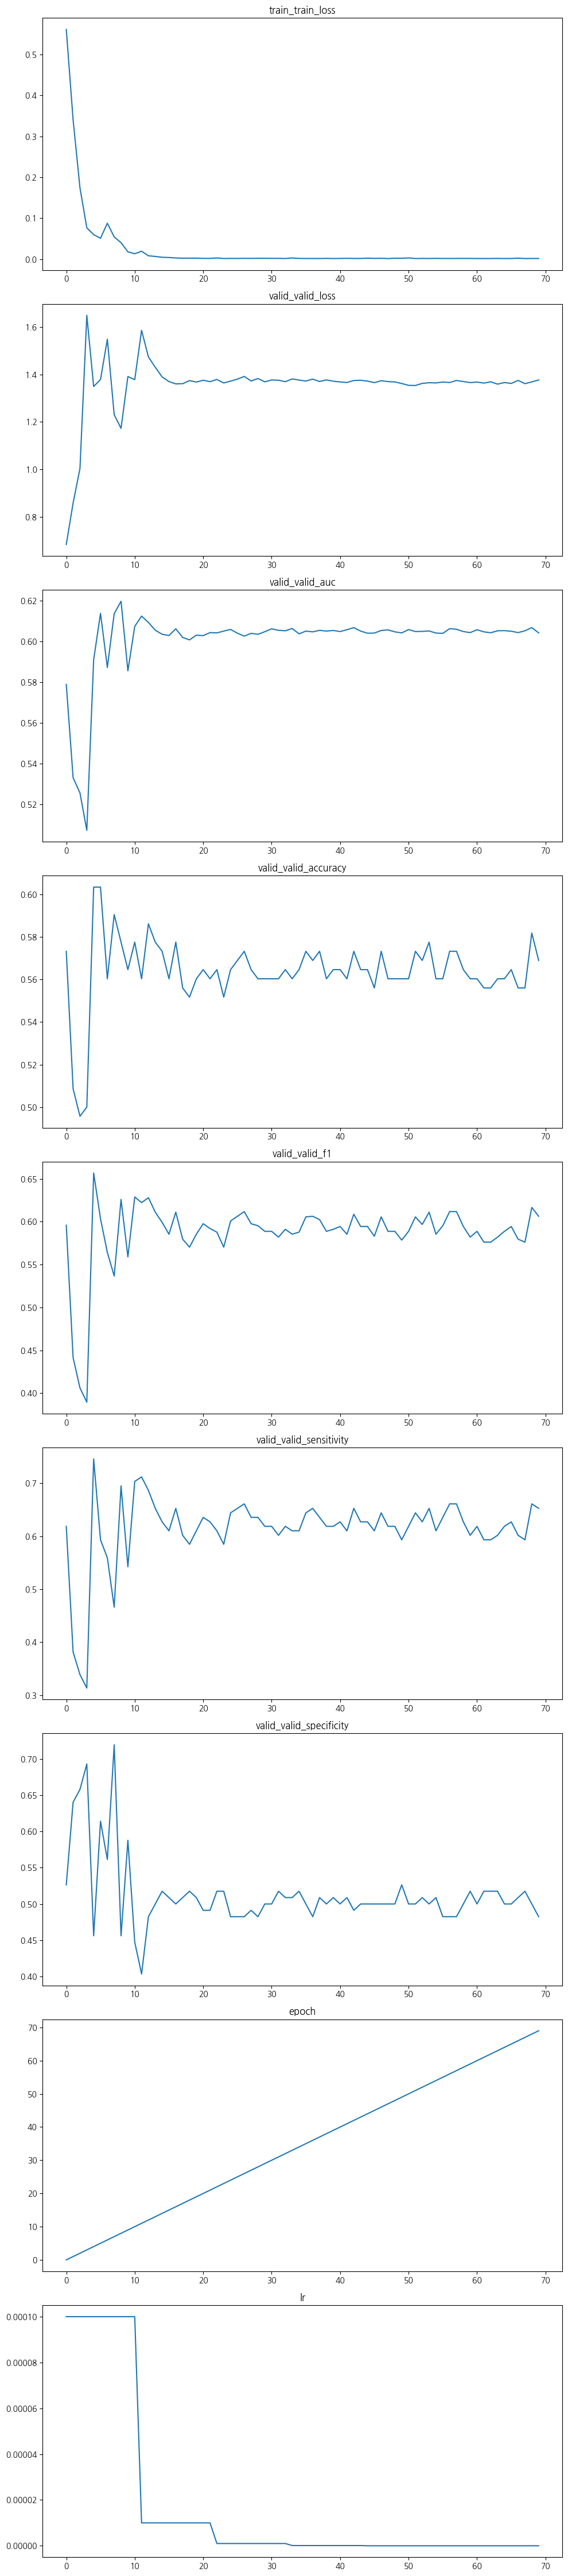

In [23]:
import glob
import numpy as np
import matplotlib.pyplot as plt

def read_log(path):
    log_list = []
    lines = open(path, 'r').read().splitlines() 
    for line in lines:
        log_list.append(eval(line))
    return log_list

# log_list = read_log(path='/workspace/sunggu/7.Mentor/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Base/log.txt')
log_list = read_log(path='/content/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Base/log.txt')

result_dict = {}
for key in log_list[0].keys():
    result_dict[key] = [log[key] for log in log_list]

fig, axs = plt.subplots(len(result_dict.keys()), 1, figsize=(10, len(result_dict.keys())*5))

for idx, key in enumerate(result_dict.keys()):
    axs[idx].plot(result_dict[key])
    axs[idx].set_title(key)
    print("###########################################################")
    print("Metric  = ", key)
    
    if "loss" in key:
        print("Argsort = ", np.argsort(result_dict[key])[:5])
        print("Value   = ", np.array(result_dict[key])[np.argsort(result_dict[key])[:5]])
    else:
        print("Argsort = ", np.argsort(result_dict[key])[::-1][:5])
        print("Value   = ", np.array(result_dict[key])[np.argsort(result_dict[key])[::-1][:5]])

plt.tight_layout()
plt.show()


## 2. Test Dataset

In [24]:
# TEST 데이터셋 생성
test_dataset = RSNA_Dataset(data_dir, csv_file, target_class, mode='test')

# DataLoader 생성
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

## 3. Load Checkpoint

In [26]:
# Metric  =  accuracy
# Argsort =  [ 4  5  7 12 68]
# Value   =  [0.60344828 0.60344828 0.59051724 0.5862069  0.58189655]

# filename = '/content/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Base'
filename = '/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/230701_ResNet50_Base/epoch_4_checkpoint.pth'

print("=> loading checkpoint '{}'".format(filename))
checkpoint  = torch.load(filename)
model.load_state_dict(checkpoint['model_state_dict'])

=> loading checkpoint 'epoch_4_checkpoint.pth'


<All keys matched successfully>

## 4. Using GPU testing

In [27]:
# using CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## 5. Test Loop

In [ ]:
'''
[Define Training & Validation Loop function]
===INSTRUCT===
딥러닝 전문가가 되어 저를 위해 코딩해 주셨으면 합니다.
'valid_loop_fn' 함수를 참고하여 'test_loop_fn' 함수를 정의하고, 실행하세요.
모델의 마지막 컨볼루션 레이어의 Grad-CAM을 그려주세요.
Test에 걸린 시간을 재주세요.

==INFO===
'valid_loop_fn'는 다음과 같습니다:
<
def valid_loop_fn(epoch, loader, model, device):
    model.eval()
    loss_meter = AverageMeter()
    outputs, targets = [], []

    with torch.no_grad():
        pbar = tqdm(loader, total=len(loader))
        for i, (image, target) in enumerate(pbar):
            image = image.float().to(device)
            target = target.float().unsqueeze(1).to(device)

            output = model(image)
            loss = loss_fn(output, target)

            loss_meter.update(loss.item(), image.size(0))
            pbar.set_postfix(loss=loss_meter.avg)

            outputs.append(output.detach().cpu())
            targets.append(target.detach().cpu())

    outputs = torch.stack(outputs).squeeze().sigmoid()
    targets = torch.stack(targets).squeeze().numpy()

    accuracy, precision, recall, f1, auc_roc = calculate_metrics(target=targets, prediction=outputs.round().numpy(), prob=outputs.numpy())

    return loss_meter.avg, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc_roc": auc_roc}
>

===TASK===
다음 절차에 따라 단계별로 진행하시기 바랍니다:
    1. test_loop_fn를 정의하세요.
    2. test_loop_fn을 수행하세요.
    3. TEST에 걸린 시간을 계산합니다.
'''

In [31]:
# 필요한 라이브러리를 가져옵니다.
import time
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# AverageMeter 클래스를 정의합니다.
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# 1단계: test_loop_fn를 정의합니다.
def test_loop_fn(loader, model, device):
    model.eval()
    outputs, targets = [], []
    start_time = time.time()

    with torch.no_grad():
        pbar = tqdm(loader, total=len(loader))
        for i, (image, target) in enumerate(pbar):
            image = image.float().to(device)
            target = target.float().unsqueeze(1).to(device)

            output = model(image)

            outputs.append(output.detach().cpu())
            targets.append(target.detach().cpu())

    outputs = torch.stack(outputs).squeeze().sigmoid()
    targets = torch.stack(targets).squeeze().numpy()

    accuracy, precision, recall, f1, auc_roc = calculate_metrics(target=targets, prediction=outputs.round().numpy(), prob=outputs.numpy())
    metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc_roc": auc_roc}

    print(f"Test Metrics: {metrics}")

    # 시간을 측정하고 출력합니다.
    end_time = time.time()
    print(f"Total test time: {end_time - start_time} seconds")

# 2단계: TEST_LOOP_FN를 실행합니다.
test_loop_fn(test_loader, model, device)


In [32]:
import time
import warnings
warnings.filterwarnings(action='ignore')

print(f"Start training")
start_time = time.time()
    
test_stats = test_loop_fn(test_loader, model, criterion, device, save_dir)
print('==> Averaged Test stats: ' + str(test_stats))

# Finish
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

Start training


Testing: (231 / 232 Steps), (test_loss=0.04656): 100%|██████████| 232/232 [01:16<00:00,  3.01it/s]

==> Averaged Test stats: {'test_loss': 1.2428160043138023, 'test_auc': 0.5961938745168004, 'test_accuracy': 0.5948275862068966, 'test_f1': 0.626984126984127, 'test_sensitivity': 0.6694915254237288, 'test_specificity': 0.5175438596491229}
Training time 0:01:16


In [ ]:
'''
[Code Completion]
===INSTRUCT===
파이토치 및 파이썬에서 AI 개발자 역할을 맡아 저를 위해 코딩해 주세요.
위 코드에 불완전한 부분이 있습니다. 코드를 다시 작성하여 완성도를 높여주세요.

===TASK===
다음은 몇 가지 필수 사항입니다:
    0. pytorch-gradcam를 설치하세요.
    1. 'test_loop_fn'에 추가적으로 Grad-CAM을 사용하여 모델의 마지막 컨볼루션 레이어에 대한 시각화 코드를 작성해주세요.
    2. grad-cam과 원본 image를 겹쳐서 보여주세요.
    3. figure의 title에 모델의 결과와 label 값을 나타내주세요.
'''

In [ ]:
# https://github.com/vickyliin/gradcam_plus_plus-pytorch/blob/master/example.ipynb

In [ ]:
# 필요한 라이브러리를 설치합니다.
!pip install pytorch-gradcam

# 필요한 라이브러리를 가져옵니다.
from gradcam.utils import visualize_cam
from gradcam import GradCAMpp, GradCAM

# test_loop_fn를 수정하고 Grad-CAM 시각화를 추가합니다.
def test_loop_fn(loader, model, device):
    model.eval()
    outputs, targets = [], []
    start_time = time.time()

    # 마지막 컨볼루션 레이어의 Grad-CAM을 설정합니다.
    grad_cam = GradCAM(model, model.model.layer4)

    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)
        target = target.float().unsqueeze(1).to(device)

        output = model(image)

        # Grad-CAM 마스크를 생성합니다.
        mask, _ = grad_cam(image)
        heatmap, result = visualize_cam(mask, image)

        outputs.append(output.detach().cpu())
        targets.append(target.detach().cpu())

        # 원본 이미지와 Grad-CAM 결과를 함께 출력합니다.
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.cpu().squeeze().numpy())
        plt.title(f"Label: {target.item()}")

        plt.subplot(1, 2, 2)
        plt.imshow(result.cpu().squeeze().numpy().transpose(1, 2, 0))
        plt.title(f"Model Result: {output.sigmoid().item()}")

        plt.show()

    outputs = torch.stack(outputs).squeeze().sigmoid()
    targets = torch.stack(targets).squeeze().numpy()

    accuracy, precision, recall, f1, auc_roc = calculate_metrics(target=targets, prediction=outputs.round().numpy(), prob=outputs.numpy())
    metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc_roc": auc_roc}

    print(f"Test Metrics: {metrics}")

    # 시간을 측정하고 출력합니다.
    end_time = time.time()
    print(f"Total test time: {end_time - start_time} seconds")

# test_loop_fn를 실행합니다.
test_loop_fn(test_loader, model, device)


In [ ]:
# pytorch-gradcam 라이브러리를 사용하여 정확한 Grad-CAM 예제를 제공하세요.

In [ ]:
import cv2
import torch
from torchvision import transforms
from torchvision.models import resnet50
from torch.autograd import Variable
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ResNet50 모델을 불러오고, eval 모드로 설정합니다.
model = resnet50(pretrained=True)
model = model.cuda()
model = model.eval()

# 이미지를 불러오고, 전처리를 합니다.
img_path = "/path/to/your/image.jpg"
img = cv2.imread(img_path, 1)
img = np.float32(img) / 255
input_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocessed_img = input_transforms(img).unsqueeze(0)
input_tensor = Variable(preprocessed_img, requires_grad=True).cuda()

# Grad-CAM을 준비합니다. 여기서는 ResNet의 마지막 conv 레이어를 대상으로 합니다.
target_layer = model.layer4[-1]
cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)

# Grad-CAM을 계산합니다.
target_category = None  # None으로 설정하면 가장 높은 점수의 카테고리가 대상이 됩니다.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# 원본 이미지에 Grad-CAM을 입힙니다.
visualization = show_cam_on_image(img, grayscale_cam)

# 결과를 시각화합니다.
plt.imshow(visualization)
plt.show()


In [ ]:
# 결과 정리

In [ ]:
'test_auc'       : 0.5961938745168004,
'test_accuracy'   : 0.5948275862068966,
'test_f1'         : 0.626984126984127,
'test_sensitivity': 0.6694915254237288,
'test_specificity': 0.5175438596491229
